In [65]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
#breakpoint()
# from tracer.build.field_routines import baxisym as bas 
from tracer.build.field_routines import trace as tr
from tracer.build.field_routines import bprecalc as bpre 
from tracer.build.field_routines import bfield as bf 
from tracer.build.field_routines import grid as gr 

from combine.quick_g import quick_g_plot
#sys.path.append('../grid/.')
#from curve import *
import tracer.W7X.Kisslinger as Kisslinger

def equal_spaced_points(x_coords, y_coords, n, x_out, y_out, pprint=False):
    # x and y coord differences between points 
    xcd = np.diff(x_coords) # 
    ycd = np.diff(y_coords)
    # calulate length of path and therefore length between points
    point_dists = (xcd**2 + ycd**2)**(1/2)
    arc_len = np.sum(point_dists)
    point_dist = arc_len/(n-1)
    if(pprint): 
        print("\n", arc_len, point_dist)
    # find coord of mth point by going along subsampling points
    # until it would be too ling, and then interpolating
    for i in range(n-1): # [0, n]
        path_len, full_len = 0, i*point_dist
        c = 0
        while True: # go along polypath
            if path_len + point_dists[c] >= full_len:
                # interpolate
                frac = (full_len - path_len)/point_dists[c]
                x_out[i] = x_coords[c] + frac*xcd[c]
                y_out[i] = y_coords[c] + frac*ycd[c]
                if(pprint): print(i, full_len)
                break
            else:
                # go to next path segment
                path_len += point_dists[c]
                c += 1
    # place last point at same coord as first one
    x_out[-1] = x_coords[0]
    y_out[-1] = y_coords[0]

In [127]:
consts = {"NirS": 5, "NirC": 5, "NirN": 10,  # in -> outside cell number 
         "Niphalf": 50,
         "eq_space": True, "eq_space_vessel": False,
         "zoidpol": False, "trace_angle": 13,
         "center_delta_R": .15}

pprint=False

if(pprint):
    print('Define grid parameters & locations')

# radial resolution of the SOL, core and outer neutral regions
NirS = consts.get("NirS", 100)
NirC = consts.get("NirC", 25)
NirN = consts.get("NirN", 5)
consts["NirS"], consts["NirC"], consts["NirN"] = NirS, NirC, NirN 


# poloidal and toroidal resolutions
Niphalf = consts.get("Niphalf", 500)
Nit = consts.get("Nit", 37)
assert(Nit == 37)
consts["Niphalf"], consts["Nit"] = Niphalf, Nit

# start in bean crossection or triangle or somewhere else?
# 0 == bean, np.pi/180 * 36 == triangle
trace_angle = consts.get("trace_angle", 0)
assert(0 <= trace_angle < Nit) # in first module
assert(type(trace_angle) == int)
consts["trace_angle"] = trace_angle * 2*np.pi/Nit/10
consts["trace_index"] = trace_angle

# bean starting points to trace to any angle
# flux surface radii for tracing for bean and triangle crossection
cax_bean = [5.944e+00, 0.0, 0.0]
Rlcfs_bean=6.2014041; dRcore=0.10; dRneut=0.3; dRSOL=-0.085 #  -0.0735

# create poloidal points equally spaced from each other?
consts["eq_space"] = consts.get("eq_space", False)
consts["eq_space_vessel"] = consts.get("eq_space_vessel", False)

# when parameterizing over the theta angle of the boundary, the vessel
# shape can in certain circumstances not be monotonically increasing
# in theta. as we are free to place the vesses grid points, this shifts
# the midpoint a bit to the outside so that the middle bean shape
# is monotonically increasing again
# the shift will vary between machines and even configurations!!!
consts["center_delta_R"] = consts.get("center_delta_R", 0)

Nir=NirC+NirS+NirN; Nip=2*Niphalf+1
consts["Nir"], consts["Nip"] = Nir, Nip

#Define magnetic field locations
dphi_fp=2*np.pi/5.0 # toroidal extension of the field period
phitri=2*np.pi/10.0 # toroidal coordinate in which the plasma has a triangular shape
phibean=0.#2*np.pi/5.0 # toroidal coordinate in which the plasma a bean shape

#--------------------------
if(pprint):
    print('load/calculate mag. field')

# pathtohere = os.path.realpath(__file__)
# pathtofolder = "/".join(pathtohere.split("/")[:-1])
pathtofolder = os.path.abspath('')
fn=f'{pathtofolder}/W7XField-EIM.dat'
#fn='W7X.dat'
bpre.restore_field(fn) # restore the result (faster than computing)

#turn on the pre-calculated 3D magnetic field and the axi-symmetric Tokamak field off
#first to components are tokamak background field, third is 3D-field (pertubation for tokamaks)
bf.scale_components([0,0,1.0])

#Define grid
g=np.zeros((Nir,Nip,Nit,3),order='F')*np.nan


#--------------------------
if(pprint):
    print('construct flux surfaces in confinement region')

# trace from bean to starting surface
ta, ti = consts["trace_angle"], consts["trace_index"]
angle_step = (phitri - phibean)/(Nit-1)
new_coords = [None]*4 # new Rfs's at new plane angle
r_indices, r_deltas = [0,1,NirC-1,NirC+NirS-1], [dRneut, dRcore, 0, dRSOL]
for i, (ifs, Rfs) in enumerate(zip(r_indices, r_deltas)):
    fl = tr.field_line([Rlcfs_bean-Rfs,0,phibean],ta,1,substeps=72,dir=1)
    new_coords[i] = fl[-1]

if(pprint):
    print('Trace mag. axis')

# trace axis starting cross section   
new_cax = tr.field_line(cax_bean,ta,1,substeps=72,dir=1)[-1]
# trace axis along whole segement
gax = tr.field_line(cax_bean,angle_step,Nit-1,substeps=72,dir=1)


#Construct a flux surface by field line tracing     
for ifs, nc in zip(r_indices, new_coords):
    if(pprint): print(ifs,Rfs)
    fl=tr.field_line(nc,dphi_fp,10*Nip,substeps=72*5,dir=1)

    # #order the points according to the theta coordinate
    thetafl=np.arctan2(fl[:,1]-new_cax[1],fl[:,0]-new_cax[0])
    ii=np.argsort(thetafl)
    fl=fl[ii];thetafl=thetafl[ii]
    fl=np.vstack((fl,fl,fl))
    thetafl=np.hstack((thetafl-2*np.pi,thetafl,thetafl+2*np.pi))

    if consts["eq_space"]: # place points an equal distance apart
        # subsample fieldlinepoints (to remove jitter)
        theta=np.linspace(-np.pi,np.pi,5*Nip)
        Rc = np.interp(theta, thetafl, fl[:,0])
        Zc = np.interp(theta, thetafl, fl[:,1])
        equal_spaced_points(Rc, Zc, Nip, g[ifs,:,ti,0], g[ifs,:,ti,1])

    else: # just place points uniformly along polidal angle
        theta=np.linspace(-np.pi,np.pi,Nip)
        g[ifs,:,ti,0]=np.interp(theta, thetafl, fl[:,0])
        g[ifs,:,ti,1]=np.interp(theta, thetafl, fl[:,1])
        


In [128]:
# quick_g_plot(g, phi=13)

In [129]:
if(pprint):
    print('extrapoloate intermediate surfaces linearily') 
x1=np.linspace(0.0,1.0,NirC-1)[1:-1]
x2=np.linspace(0.0,1.0,NirS+1)[1:]

irin=1;irsep=NirC-1;irneut=NirC+NirS-1
for ip in range(Nip):    
    for ic in range(2):
        g[irin +1:irsep  ,ip,ti,ic] = g[irin ,ip,ti,ic]+\
                    (g[irsep,ip,ti,ic]-g[irin,ip,ti,ic])*x1
        g[irsep+1:irneut+1,ip,ti,ic] = g[irsep,ip,ti,ic]+\
                    (g[irneut,ip,ti,ic]-g[irsep,ip,ti,ic])*x2
#--------------------------
if(pprint):
    print('force possible up/down symmetry in triangular plane.')
if(ta == 0 or ta == Nir-1):
    for ir in range(Nir):
        #ir=NirC+NirS+i
        for ip in range(Niphalf+1):
            g[ir,Nip-1-ip,ti,0]= g[ir,ip,ti,0]
            g[ir,Nip-1-ip,ti,1]=-g[ir,ip,ti,1]

g[:,:,ti,2] = ta

#--------------------------
if(pprint):
    print('extend along fieldline')
for ir in range(Nir):
    for ip in range(Nip):  
        # note that Nit (and not Nit-1) points along the fieldline
        # are given back in the trace routine

        # trace forward
        g[ir,ip,ti:] = tr.field_line(g[ir,ip,ti], angle_step, Nit-1-ti, substeps=10, dir=1)

        # trace backward
        g[ir,ip,:ti+1] = tr.field_line(g[ir,ip,ti], angle_step, ti, substeps=10, dir=-1)

<IPython.core.display.Javascript object>


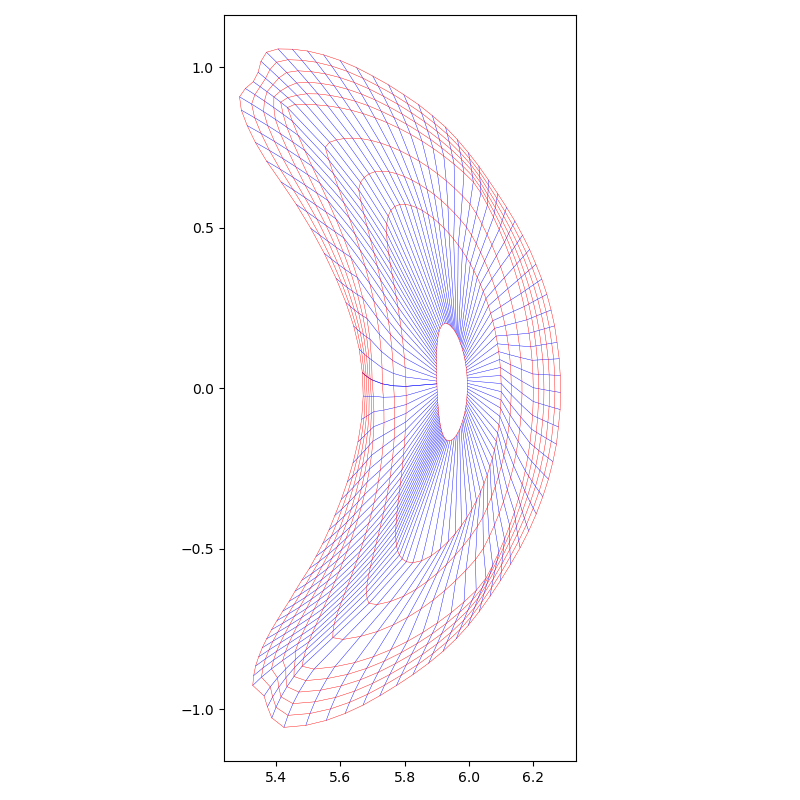

In [136]:
quick_g_plot(g, phi=1)